# Import Statements

In [1]:
import numpy as np
import networkx as nx
import math
import time
from scipy.interpolate import UnivariateSpline
import osmnx as ox
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
from networkx.algorithms.flow import shortest_augmenting_path

# Functions to Build Real-world Graph

In [2]:
MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        G[u][v][i]["upper"] = int(method(lanes, edge_data["speed_kph"]))
    return G

In [3]:
###don't need for max flow/quickest flow
def add_costs(G, costs:[int, np.ndarray] = 0):
    if type(costs) == int:
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs
    else:
        count = 0
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs[count]
    return G

In [4]:
def add_orig_dest(G, sup_dem:[int, np.ndarray]):
    if type(sup_dem) == int:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem
    else:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem[i]
    return G

In [5]:
def proj_lat_lngs(lats, lngs, G):
    #convert lat and longs to point geometry
    pnts_list = [Point((lng, lat)) for lat, lng in zip(lats, lngs)]
    
    #convert list of points into Geoseries of points
    #(EPSG:4326 is WGS84)
    pnts = gpd.GeoSeries(pnts_list, crs='epsg:4326')
    
    #convert points to CRS from OSMNX projection
    proj_pnts = pnts.to_crs(G.graph['crs'])
    return proj_pnts

def switch(key):
    if key == "Boulder":
        return (479800,4424260,489130,4429760)
    elif key == "Pueblo":
        return (5255180,4250280,514380,4423270)
    elif key == "Lyons":
        return (477230,4453570,476140,4430890)
    elif key == "Jefferson":
        return (489685,4379999,494940,4393420)
    elif key == "Sonoma":
        return (512007,4273277,525300,4255270)
    elif key == "Butte":
        # return (621540,4406520,599230,4400090)
        df_sinks = pd.read_csv('optimal_sinks.csv')  
        df_sources = pd.read_csv('sources.csv')
        lat = [df_sinks['lat'][0],df_sources['lat'][0]]
        long = [df_sinks['lon'][0],df_sources['lon'][0]]
        return (lat, long)
    else:
        raise Exception("Please enter a valid location.")
        exit()
        
###find nodes in network closestest to desired destinations
def orig_dest_nodes(network,location):
    ###do not test Butte yet (prjections might be weird)
    if location == "Butte":
        lat,long = switch(location)
        proj_sink_source = proj_lat_lngs(lat, long, network)
        orig=ox.distance.nearest_nodes(network,proj_sink_source.x[1],proj_sink_source.y[1],return_dist=False)
        dest=ox.distance.nearest_nodes(network,proj_sink_source.x[0],proj_sink_source.y[0],return_dist=False)
    else:
        lat_start,long_start,lat_end,long_end = switch(location)
        orig=ox.distance.nearest_nodes(network,lat_start,long_start,return_dist=False)
        dest=ox.distance.nearest_nodes(network,lat_end,long_end,return_dist=False)
    return orig, dest

# Functions to set up for Max Flow Alogirthm

In [6]:
def add_s_t(G, ten, time_horizon,removed_nodes_mat):
    start = time.time()
    ten_copy = ten.copy()
    orig_nodes = list(G.nodes)
    ten_nodes = list(ten_copy.nodes)

    sup_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    
    s = 0
    t = max(ten_nodes)+1
    
    ten_copy.add_node(s,name = f'{s}-{0}',level = 0)
    ten_copy.add_node(t,name = f'{len(orig_nodes)}-{time_horizon-1}',level = time_horizon-1)
    
    for i in range(len(orig_nodes)):
        if i in sup_nodes:
            ten_copy.add_edge(s, i+1, cost = 0, upper = G._node[i]['sup_dem'], lower = 0)
        elif i in dem_nodes:
            ###need to add in check for last time interval node is still available
            for k in range(time_horizon-1):
                added = False
                if i in removed_nodes_mat[k+1]:
                    ten_copy.add_edge((i+1) + ((k) * len(orig_nodes)),t, upper = -G._node[i]['sup_dem'], lower = 0)
                    added = True
                    break;
            if added is False:
                ten_copy.add_edge((i+1) + ((time_horizon-1) * len(orig_nodes)),t, upper = -G._node[i]['sup_dem'], lower = 0)

    end = time.time()
    print('Add Super Source and Sink Time: ',end-start)

    
    
    return ten_copy

In [7]:
###handled in TEN construction instead
def simplify_multigraph(graph):
    start = time.time()
    num_nodes = max(graph.nodes)
    edges = graph.edges
    
    simp_graph = nx.DiGraph()
    simp_graph.add_nodes_from(graph.nodes(data=True))
    
    for i in range(num_nodes+1):
        for j in range(num_nodes+1):
            if (i,j) in edges:
                num_edges = graph.number_of_edges(i,j)
                tot_cap = graph[i][j][num_edges-1]['upper']
                if num_edges > 1:
                    for k in range(1,num_edges):
                        tot_cap = tot_cap + graph[i][j][k]['upper']
                simp_graph.add_edge(i,j, upper = tot_cap, lower = 0)
    end = time.time()  
    print('Conversion to Digraph Time: ',end-start)
    return simp_graph

In [8]:
def color_max_flow(graph, flow_dict):
    edges = graph.edges

    for (i,j) in edges:
        graph[i][j]['color'] = (0,0,0)
        if flow_dict[i][j] !=0:
            graph[i][j]['color'] = (1,0,0)
                    
    return graph

# Functions to Include Fire Data with Graph

In [9]:
def geodesic_point_buffer(graph,lat, lon, radius):
    """
    Creates circles from given latitude, longitude, and radius
    :param lat: latitude from original data
    :param lon: longitude from original data
    :param radius: radius from original data
    """
    # Azimuthal equidistant projection
    aeqd_proj = CRS.from_proj4(f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(radius * 1609.34)  # distance in miles (converts from meters to miles)
    circle = Polygon(transform(tfmr.transform, buf).exterior.coords[:])
    net_trans = Transformer.from_crs(aeqd_proj.geodetic_crs, graph.graph['crs'])
    proj_circ = Polygon(transform(net_trans.transform,circle).exterior.coords[:])
    
    return proj_circ

In [10]:
def det_rem_parts(G, fire_polygon, smoke_polygon):
    ###find nodes inside poly to remove
    start_gs = time.process_time()
    gs_nodes = ox.utils_graph.graph_to_gdfs(G,nodes = True,edges = False, node_geometry = True)[['geometry']]
    gs_edges = ox.utils_graph.graph_to_gdfs(G,nodes = False, edges = True)[['geometry']]
    end_gs = time.process_time()

    nodes_to_remove = []
    edges_to_remove = []
    start_to_remove = time.process_time()
    for point in gs_nodes['geometry']:
        if point.intersects(smoke_polygon):
            node = ox.distance.nearest_nodes(G,point.x,point.y,return_dist=False)
            nodes_to_remove.append(node)
    for i in range(len(gs_edges)):
        entry =  gs_edges.iloc[i]
        if entry['geometry'].intersects(fire_polygon):
            entry = gs_edges.iloc[[i]]
            edges_to_remove.append(entry['geometry'].index[0])
    end_to_remove = time.process_time()

    return (nodes_to_remove, edges_to_remove)

In [11]:
def create_fire_mat(G, fire_origin, init_radius, time_horizon, removed_node_mat, removed_edge_mat):
    start = time.time()
    time_ints_done = len(removed_node_mat)-1

    for i in range(time_ints_done,time_horizon):
        ###create fire_poly and smoke_poly in coordinate system of network
        # radius = init_radius+(0.00025*i)
        radius = init_radius
        fire_polygon = geodesic_point_buffer(G,fire_origin[0],fire_origin[1],radius)
        smoke_polygon = geodesic_point_buffer(G,fire_origin[0],fire_origin[1],radius*1.01)
                                              
        removed_nodes,removed_edges = det_rem_parts(G, fire_polygon, smoke_polygon)
        
        removed_node_mat.append(removed_nodes)
        removed_edge_mat.append(removed_edges)
        
    end = time.time()
    print(f"Time to do Fire Poly for Time Horizon {time_horizon}: {end - start}")
    
    return (removed_node_mat, removed_edge_mat)

# Create TEN (accounts for removed nodes and arcs)

In [12]:
def time_expand_with_removal(G, time_int_size, time_horizon,removed_nodes_mat, removed_edges_mat):
    start = time.time()
    orig_nodes = list(G.nodes)
    orig_edges = list(G.edges)
    ten = nx.DiGraph()

    ###add in all nodes for time-expanded network
    node_num = 1
    for j in range(time_horizon):
        for i in range(len(orig_nodes)):
            #check that i is not one of nodes that have been removed during that time interval
            if i not in removed_nodes_mat[j]:
                if j == 0:
                    node_name = f'{i+1}-{j}'
                    ten.add_node(node_num, name = node_name, level = j, sup_dem = G._node[i]['sup_dem'])
                else:
                    node_name = f'{i+1}-{j}'
                    ten.add_node(node_num, name = node_name, level = j, sup_dem = 0)
            node_num += 1
            
    ###add in hold over arcs for supply/demand nodes
    for i in range(len(orig_nodes)):
        if G._node[i]['sup_dem'] >  0:
            for j in range(time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  G._node[i]['sup_dem'] , lower = 0)
        elif G._node[i]['sup_dem'] <  0:
            for j in range(time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  -G._node[i]['sup_dem'] , lower = 0 )

    ###in the case of a multidigraph
    if G.is_multigraph():
        node_num = 0
        for j in range(time_horizon-1):
            for i in range(len(orig_nodes)):
                ###keep track of node number for the overall network (need to account for nodes in the expansions)
                node_num +=1
                if i not in removed_nodes_mat[j]:
                    for k in range(len(orig_nodes)):
                        for m in range(G.number_of_edges(i,k)+1):
                            ###check if edge exists in graph
                            if (i,k,m) in orig_edges and (i,k,m) not in removed_edges_mat[j]:
                                ###deteremine how many time intervals it will cross
                                time_int_end = math.ceil(G[i][k][m]['travel_time']/time_int_size)
                                ###check if the number it crosses exist in the network
                                if time_int_end+j < time_horizon:
                                    ###check that end node exists during that time interval
                                    if k not in removed_nodes_mat[time_int_end+j]:
                                        ####add edge to time-expanded networkif not already exist
                                        if (node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end)) in ten.edges:
                                            ten[node_num][(node_num)+(k-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][k][m]['upper']
                                        else:
                                            ten.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),upper = G[i][k][m]['upper'], lower = 0)

    ##in the case of a digraph that is not a multdigraph
    elif G.is_directed():
        node_num = 0
        for j in range(time_horizon-1):
            for i in range(len(orig_nodes)):
                ###keep track of node number for the overall network (need to account for nodes in the expansions)
                node_num +=1
                if i not in removed_nodes_mat[j]:
                    for k in range(len(orig_nodes)):
                        ###check if edge exists in graph
                        if (i,k) in orig_edges and (i,k) not in removed_edges_mat[j]:
                            ###deteremine how many time intervals it will cross
                            time_int_end = math.ceil(G[i][k]['travel_time']/time_int_size)
                            ###check if the number it crosses exist in the network
                            if time_int_end+j < time_horizon:
                                ###check that end node exists during that time interval
                                if k not in removed_nodes_mat[time_int_end+j]:
                                    ####add edge to time-expanded network if not already exist
                                    if (node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end)) in ten.edges:
                                            ten[node_num][(node_num)+(k-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][k]['upper']
                                    else:
                                        ten.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),upper = G[i][k]['upper'], lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")

    ###Remove isolated nodes in TEN (could occur if all edges between nodes are effected by fire, but nodes not within fire polygon)
    ten.remove_nodes_from(list(nx.isolates(ten)))
    
    end = time.time()
    ###used for checking how long larger networks/expansions take to construct
    if end-start > 1:
        print(f'Time to build TEN for T = {time_horizon}: {end-start}')

    return ten

In [46]:
def time_expand_with_removal_dyn(G, ten, time_int_size, prev_time_horizon, curr_time_horizon,removed_nodes_mat, removed_edges_mat):
    start = time.time()
    orig_nodes = list(G.nodes)
    orig_edges = list(G.edges)
    ten_copy = ten.copy()

    ###add in all nodes for time-expanded network
    if prev_time_horizon == 0:
        node_num = 1
    else:
        node_num = len(orig_nodes)*prev_time_horizon+1
            
    for j in range(prev_time_horizon,curr_time_horizon):
        for i in range(len(orig_nodes)):
            #check that i is not one of nodes that have been removed during that time interval
            if i not in removed_nodes_mat[j]:
                if j == 0:
                    node_name = f'{i+1}-{j}'
                    ten_copy.add_node(node_num, name = node_name, level = j, sup_dem = G._node[i]['sup_dem'])
                else:
                    node_name = f'{i+1}-{j}'
                    ten_copy.add_node(node_num, name = node_name, level = j, sup_dem = 0)
            node_num += 1
            
    ###add in hold over arcs for supply/demand nodes
    if prev_time_horizon ==0:
        start_time_int = prev_time_horizon
    else:
        start_time_int = prev_time_horizon-1
    for i in range(len(orig_nodes)):
        if G._node[i]['sup_dem'] >  0:
            for j in range(start_time_int,curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  G._node[i]['sup_dem'] , lower = 0)
        elif G._node[i]['sup_dem'] <  0:
            for j in range(start_time_int,curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  -G._node[i]['sup_dem'] , lower = 0 )

    new_nodes = np.array(range((len(orig_nodes)*prev_time_horizon)+1, (len(orig_nodes)*curr_time_horizon)+1))
    # print(len(new_nodes))
    ###in the case of a multidigraph
    if G.is_multigraph():
        for (i,j,k) in orig_edges:
            # print(f'({i},{j},{k})')
            time_int_end = math.ceil(G[i][j][k]['travel_time']/time_int_size)
            for m in range(curr_time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                if ((i,j,k) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                    if prev_time_horizon == 0 or (node_num)+(j-i)+(len(orig_nodes)*time_int_end) in new_nodes:
                        if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
                            ten_copy[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j][k]['upper']
                        else:
                            # print('edge added')
                            ten_copy.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j][k]['upper'], lower = 0)
                    
                    


        
        # node_num = 0
        # for j in range(curr_time_horizon-1):
        #     for i in range(len(orig_nodes)):
        #         ###keep track of node number for the overall network (need to account for nodes in the expansions)
        #         node_num +=1
        #         if i not in removed_nodes_mat[j]:
        #             for k in range(len(orig_nodes)):
        #                 for m in range(G.number_of_edges(i,k)+1):
        #                     ###check if edge exists in graph
        #                     if (i,k,m) in orig_edges and (i,k,m) not in removed_edges_mat[j]:
        #                         ###deteremine how many time intervals it will cross
        #                         time_int_end = math.ceil(G[i][k][m]['travel_time']/time_int_size)
        #                         ###check if the number it crosses exist in the network
        #                         if time_int_end+j < curr_time_horizon:
        #                             ###check that end node exists during that time interval
        #                             if k not in removed_nodes_mat[time_int_end+j]:
        #                                 ####add edge to time-expanded networkif not already exist
        #                                 if prev_time_horizon == 0 or (node_num)+(k-i)+(len(orig_nodes)*time_int_end) in new_nodes:
        #                                     if (node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
        #                                         ten_copy[node_num][(node_num)+(k-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][k][m]['upper']
        #                                     else:
        #                                         # print('edge added')
        #                                         ten_copy.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),upper = G[i][k][m]['upper'], lower = 0)

    ##in the case of a digraph that is not a multdigraph
    elif G.is_directed():
        for (i,j) in orig_edges:
            # print(f'({i},{j},{k})')
            time_int_end = math.ceil(G[i][j]['travel_time']/time_int_size)
            for m in range(curr_time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                if ((i,j) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                    if prev_time_horizon == 0 or (node_num)+(j-i)+(len(orig_nodes)*time_int_end) in new_nodes:
                        if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
                            ten_copy[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j]['upper']
                        else:
                            # print('edge added')
                            ten_copy.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j]['upper'], lower = 0)

        
        # node_num = 0
        # for j in range(curr_time_horizon-1):
        #     for i in range(len(orig_nodes)):
        #         ###keep track of node number for the overall network (need to account for nodes in the expansions)
        #         node_num +=1
        #         if i not in removed_nodes_mat[j]:
        #             for k in range(len(orig_nodes)):
        #                 ###check if edge exists in graph
        #                 if (i,k) in orig_edges and (i,k) not in removed_edges_mat[j]:
        #                     ###deteremine how many time intervals it will cross
        #                     time_int_end = math.ceil(G[i][k]['travel_time']/time_int_size)
        #                     ###check if the number it crosses exist in the network
        #                     if time_int_end+j < curr_time_horizon:
        #                         # print(time_int_end+j)
        #                         ###check that end node exists during that time interval
        #                         if k not in removed_nodes_mat[time_int_end+j]:
        #                             ####add edge to time-expanded network if not already exist
        #                             if prev_time_horizon == 0 or ((node_num)+(k-i)+(len(orig_nodes)*time_int_end) in new_nodes):
        #                                 # print(f'({node_num},{(node_num)+(k-i)+(len(orig_nodes)*time_int_end)})')
        #                                 if (node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
        #                                         ten_copy[node_num][(node_num)+(k-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][k]['upper']
        #                                 else:
        #                                     # print('edge added')
        #                                     ten_copy.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),upper = G[i][k]['upper'], lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")

    ###Remove isolated nodes in TEN (could occur if all edges between nodes are effected by fire, but nodes not within fire polygon)
    ###Removed this function to cut down on work for adding new time intervals
    # ten.remove_nodes_from(list(nx.isolates(ten)))
    
    end = time.time()
    ###used for checking how long larger networks/expansions take to construct
    # if end-start > 1:
    print(f'Time to build TEN for T = {curr_time_horizon}: {end-start}')

    return ten_copy

# Determine number of Time Intervals to Evacuate People (and Max Flow)

In [50]:
def det_num_int(G, pop, fire_orgin, init_radius):

    
    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    sup_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
    longest_time = 0
    supply_amt = 0
    demand_amt = 0
    
    ### determine if problem will have a solution
    start = time.time()
    for i in sup_nodes:
        supply_amt = supply_amt + G._node[i]['sup_dem']
    for j in dem_nodes:
        demand_amt = demand_amt - G._node[j]['sup_dem']
    
    if supply_amt != demand_amt:
        raise Exception("Supply does not equal demand. Please adjust values accordingly.")
        exit()
    elif supply_amt < pop:
        raise Exception("Population is larger than supply. Not possible to evacuate everyone.")
        exit()
    end = time.time()
    print(f'Feasability Check Completed: {end-start} seconds') 
    ###deteremine minimum number of time intervals by finding the longest time to travel between any of the sources or sinks
    start = time.time()
    for source in sup_nodes:
        for sink in dem_nodes:
            current_travel_time = nx.shortest_path_length(G, source, sink, 'travel_time')
            if current_travel_time >= longest_time:
                longest_time = current_travel_time
                shortest_path = nx.shortest_path(G, source, sink,'travel_time')
    end = time.time()
    print(f'Longest Path Deteremined: {end-start} seconds') 
                
    time_int_len = 1
    num_time_ints = math.ceil(longest_time)+len(shortest_path) ###time zero is when num_time_ints = 1
    prev_num_time_ints = 0

    ten = nx.DiGraph()
    prev_ten = ten.copy()
    s_t_ten = nx.DiGraph()
    flow_value = 0
    flow_dict = {}
    removed_nodes_mat = []
    removed_edges_mat = []

    while flow_value < pop:
    # while num_time_ints < math.ceil(longest_time)+len(shortest_path)+3:
        # print('number prev ten nodes: ',len(prev_ten.nodes))
        
        removed_nodes_mat,removed_edges_mat = create_fire_mat(G,fire_origin, init_radius, num_time_ints,removed_nodes_mat,removed_edges_mat)
        if (dem_nodes in removed_nodes_mat[-1]):
            print(f"All sinks have been taken by the fire, not everyone can evacuate by time horizon {time_horizon}.")
            print(f"Will return solution for time horizon{num_time_ints-1}")
            time_horizon = time_horizon-1

            ten = time_expand_with_removal_dyn(G, prev_ten, time_int_len, prev_num_time_ints,num_time_ints, removed_nodes_mat, removed_edges_mat)
            # ten = time_expand_with_removal(G, time_int_len,num_time_ints, removed_nodes_mat, removed_edges_mat)
            s_t_ten = add_s_t(G, ten, num_time_ints, removed_nodes_mat)
            flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)
            break;
        else:
            ten = time_expand_with_removal_dyn(G, prev_ten, time_int_len, prev_num_time_ints,num_time_ints, removed_nodes_mat, removed_edges_mat)
            # ten = time_expand_with_removal(G, time_int_len,num_time_ints, removed_nodes_mat, removed_edges_mat)
            # print('number orig ten nodes: ',len(ten.nodes))
            s_t_ten = add_s_t(G, ten, num_time_ints, removed_nodes_mat)
            # print('number super s_t ten nodes: ',len(s_t_ten.nodes))
            start = time.time()
            flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)
            end = time.time()
            print(f'Time for Max Flow Algorithm {end-start} seconds')
            print('----------------------------------------------------------------------')

            prev_ten = ten.copy()
            prev_num_time_ints = num_time_ints
            num_time_ints +=1

    start = time.time()
    colored_max_flow_ten = color_max_flow(s_t_ten,flow_dict)
    end = time.time()
    print(f'Time to color edges with Flow in TEN: {end-start}')
    ###code used for plotting colored max-flow on TEN
    # num_nodes = max(list(colored_max_flow_ten))
    # pos = nx.multipartite_layout(s_t_ten, subset_key="level")
    # pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
    # pos[max(s_t_ten.nodes)] = np.array([pos[max(s_t_ten.nodes)-1][0]+0.05,pos[max(s_t_ten.nodes)-1][1]])
    # colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
    # nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)
    
    return (num_time_ints-1, flow_value, flow_dict, colored_max_flow_ten) 

# Build Real-world Graph

In [15]:
def construct_orig_graph(location, sup_dem_nodes):

    start = time.time()
    #import data from osmnx, can input any city, state, etc.
    G = ox.project_graph(ox.graph_from_place(location, network_type='drive'))
    print('Importing Network Complete')

    #get rid of intersections that are not actually intersections
    G = ox.simplification.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
    print('Consolidation Complete')

    #add edge speeds
    G = ox.speed.add_edge_speeds(G)
    print('Speed Added')

    #add travel times
    G = ox.speed.add_edge_travel_times(G)
    print('Travel Time Added')

    #add capacities (computed using moore method)
    G = add_capacities(G)
    print('Capacities Added')

    ###only need if doing something with min-cost
    # costs = 0
    # G = add_costs(G,costs)
    # print('Costs Added')

    #sup_dem:int = 0
    # orig,dest = orig_dest_nodes(G,"Lyons")
    sup_dem = np.zeros(len(G.nodes))
    # sup_dem[orig] = 2000
    # sup_dem[dest] = -2000
    # sup_dem[10] = 2000
    # sup_dem[max(G.nodes)] = -2000
    for i,j in sup_dem_nodes:
        sup_dem[i] = j
    G = add_orig_dest(G,sup_dem)
    print('Supply and Demand Values Added')

    end = time.time()

    print('Time to Build Original Network: ',end-start, ' seconds')
    
    return G

# Evacuation Code

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  1.021068811416626  seconds


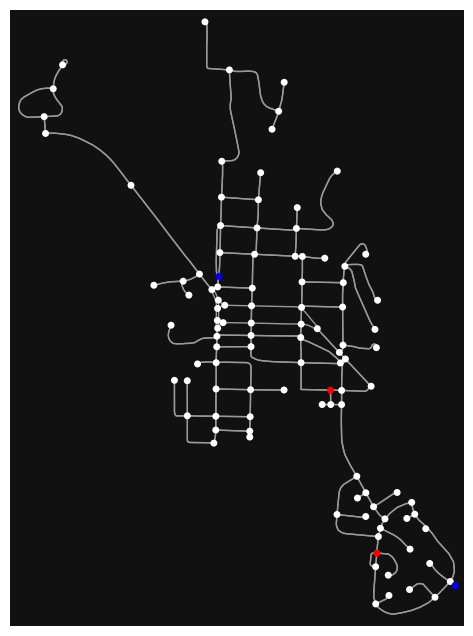

Feasability Check Completed: 0.0 seconds
Longest Path Deteremined: 0.0016014575958251953 seconds
Time to do Fire Poly for Time Horizon 161: 17.4847514629364
Time to build TEN for T = 161: 0.2479860782623291
number orig ten nodes:  17227
Add Super Source and Sink Time:  0.47100043296813965
Time for Max Flow Algorithm 1.6299824714660645 seconds
----------------------------------------------------------------------
Time to color edges with Flow in TEN: 0.0469508171081543
Number of Time Intervals: 161
Flow Value: 8000.0


In [49]:
fire_origin = [40.229520, -105.263912]
# fire_origin = [40.213739, -105.279067]
fire_radius =  0

location = 'Lyons Colorado'
sup_dem_nodes = [(1,4000),(30,4000),(15,-4000),(20,-4000)]
G = construct_orig_graph(location,sup_dem_nodes)
colors=['red' if y['sup_dem'] < 0 else 'blue' if y['sup_dem'] > 0 else 'white' for x,y in G.nodes(data=True)]
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 25, node_color = colors)
plt.show()

num_time_ints, max_flow,flow_dict, G_test = det_num_int(G, 60, fire_origin, fire_radius)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  1.0950818061828613  seconds


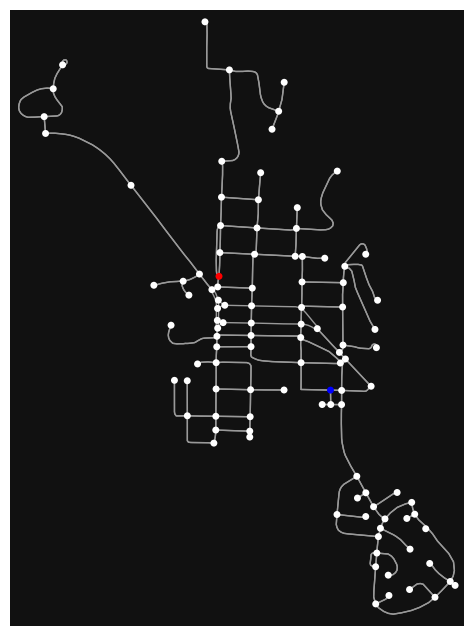

Feasability Check Completed: 0.0 seconds
Longest Path Deteremined: 0.0 seconds
Time to do Fire Poly for Time Horizon 89: 9.833802461624146
Time to build TEN for T = 89: 0.11695671081542969
Add Super Source and Sink Time:  0.08989191055297852
Time for Max Flow Algorithm 1.1777865886688232 seconds
----------------------------------------------------------------------
Time to do Fire Poly for Time Horizon 90: 0.10675644874572754
Time to build TEN for T = 90: 0.2600843906402588
Add Super Source and Sink Time:  0.07497906684875488
Time for Max Flow Algorithm 0.9584553241729736 seconds
----------------------------------------------------------------------
Time to do Fire Poly for Time Horizon 91: 0.09814095497131348
Time to build TEN for T = 91: 0.25630879402160645
Add Super Source and Sink Time:  0.08194708824157715
Time for Max Flow Algorithm 0.9607644081115723 seconds
----------------------------------------------------------------------
Time to do Fire Poly for Time Horizon 92: 0.1324746

In [51]:
# fire_origin_2 = [40.229520, -105.263912]
fire_origin = [40.213739, -105.279067]
fire_radius =  0

location = 'Lyons Colorado'
sup_dem_nodes_2 = [(15,18000),(30,-18000)]
G_2 = construct_orig_graph(location,sup_dem_nodes_2)
colors_2=['red' if y['sup_dem'] < 0 else 'blue' if y['sup_dem'] > 0 else 'white' for x,y in G_2.nodes(data=True)]
fig,ax = ox.plot_graph(G_2,show = False, close = False,node_size = 25, node_color = colors_2)
plt.show()

num_time_ints, max_flow,flow_dict, G_test = det_num_int(G_2,17000, fire_origin, fire_radius)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)

### Testing Dynamic Updating of TEN

In [28]:
toy_net = nx.DiGraph()
toy_net.add_nodes_from(range(4))
toy_net.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)], cost = 0)
toy_net[0][1]['travel_time'] = 4
toy_net[0][2]['travel_time'] = 2
toy_net[1][2]['travel_time'] = 3
toy_net[1][3]['travel_time'] = 1
toy_net[2][3]['travel_time'] = 1
toy_net[0][1]['upper'] = 3
toy_net[0][2]['upper'] = 4
toy_net[1][2]['upper'] = 3
toy_net[1][3]['upper'] = 2
toy_net[2][3]['upper'] = 4
toy_net.nodes[0]['sup_dem'] = 9
toy_net.nodes[1]['sup_dem'] = 0
toy_net.nodes[2]['sup_dem'] = 0
toy_net.nodes[3]['sup_dem'] = -9

Time to build TEN for T = 3: 0.0011510848999023438


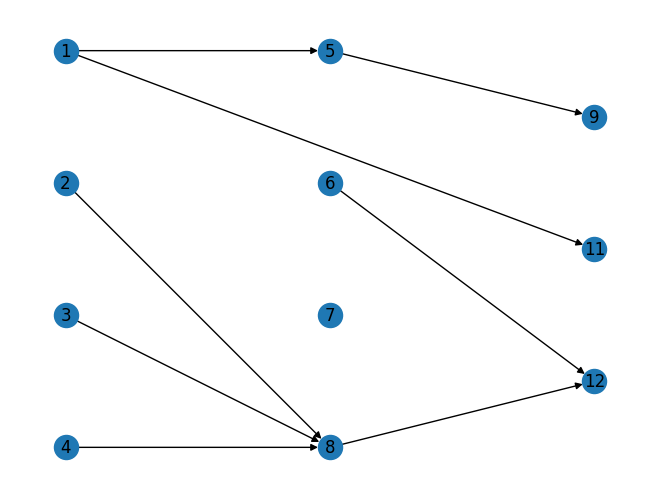

In [47]:
test_copies = 3
test_time_int = 1
test_ten = time_expand_with_removal_dyn(toy_net,nx.DiGraph(),test_time_int,0,test_copies,[[],[],[1]],[[],[(2,3)],[]])
pos = nx.multipartite_layout(test_ten, subset_key="level")
nx.draw(test_ten, pos, with_labels=True)

Time to build TEN for T = 4: 0.0020966529846191406


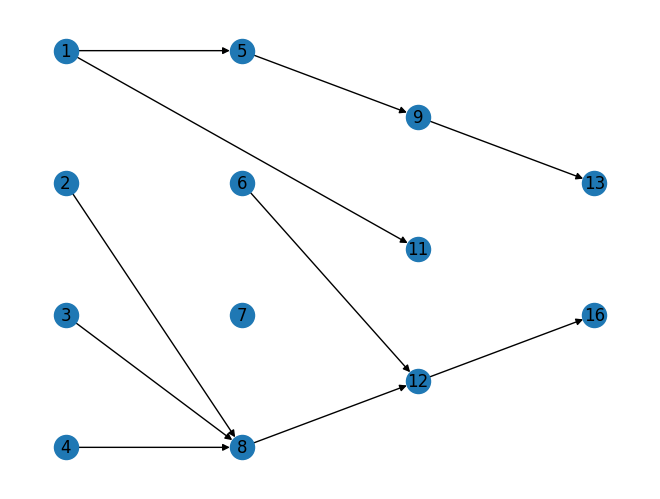

In [48]:
test_copies = 4
test_time_int = 1
test_ten_2 = time_expand_with_removal_dyn(toy_net,test_ten,test_time_int,3,test_copies,[[],[],[1],[1,2]],[[],[(2,3)],[(2,3),(1,3)],[]])
pos = nx.multipartite_layout(test_ten_2, subset_key="level")
nx.draw(test_ten_2, pos, with_labels=True)

# Code for Reconsructing Flow Paths in Original Network (Still Under Construction)

In [17]:
###Dijkstra's algorithm (with some modifications)
def find_all_paths(edge_list, start, ends, path=[]):
        # print(start)
        path = path + [start]
        if start in ends:
            return [path]
        if start not in [edge[0] for edge in edge_list]:
            return []
        paths = []
        for node in [edge[0] for edge in edge_list]:
            if node not in path and node in [edge[1] for edge in edge_list if edge[0] == start]:
                newpaths = find_all_paths(edge_list, node, ends, path)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

In [18]:
edges_w_flow = [(x[0],x[1]) for x in G_test.edges(data = True) if G_test[x[0]][x[1]]['color'] == (1,0,0)]
edges_w_flow.sort(key=lambda tup: tup[0])


start = min(G_test.nodes)
end = max(G_test.nodes)
starts = [edge[1] for edge in edges_w_flow if edge[0]==start]
ends = [edge[0] for edge in edges_w_flow if edge[1]==end]

In [19]:
paths = find_all_paths(edges_w_flow, start, ends, path=[])

In [21]:
valid_paths = []
for path in paths:
    if nx.is_path(G_test, path) and path not in valid_paths:
        valid_paths.append(path)

In [23]:
def remove_dups(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [24]:
def orig_graph_path(ten, paths, endpoints):
    orig_paths = []
    for path in paths:
        orig_path = []
        for node in path:
            # print(node)
            if node not in endpoints:
                nodes = [y['name'] for x,y in ten.nodes(data=True) if x == node]
                # print(nodes)
                node_str = nodes[0].split('-')
                orig_node = node_str[0]
                # print(int(orig_node))
                orig_path.append(int(orig_node)-1)
        orig_paths.append(remove_dups(orig_path))
        # orig_paths.append(orig_path)
    return orig_paths

In [25]:
valid_orig_paths = orig_graph_path(G_test, valid_paths, [start, end])
# for path in valid_orig_paths:
#     if nx.is_path(G, path):
#         print(path)
#         print('valid path')

[57, 59, 82, 42, 40, 43, 28, 26, 29, 47, 48, 50, 16, 12, 14, 23, 19, 17, 20, 62, 77]
valid path
[57, 59, 82, 42, 40, 41, 28, 26, 29, 47, 48, 50, 16, 12, 14, 23, 19, 17, 20, 62, 77]
valid path


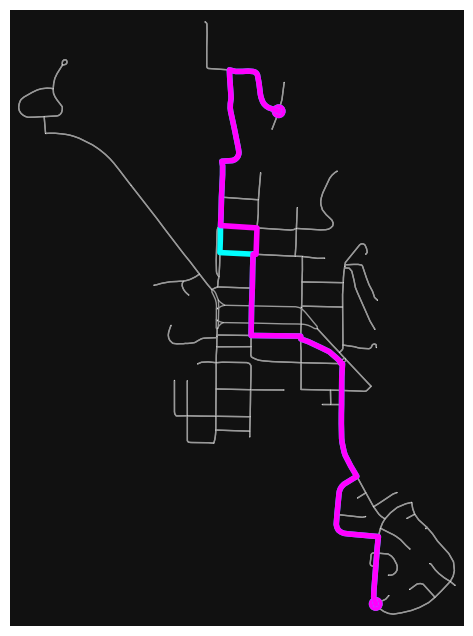

In [27]:
cl = np.array(ox.plot.get_colors(len(valid_orig_paths),cmap = "cool",return_hex = True))
fig, ax = ox.plot_graph_routes(G, valid_orig_paths, route_colors=cl, route_linewidth=3, node_size=0.5, show = False, close = False, route_alpha = 1)